In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
import featuristic as ft
import numpy as np

np.random.seed(8888)

print(ft.__version__)

1.0.0


### Load the Data

In [3]:
X, y = ft.fetch_wine_dataset()

X.head()

,alcohol,malicacid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0d280_0d315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

### Genetic Feature Synthesis

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

synth = ft.GeneticFeatureSynthesis(
    num_features=5,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    parsimony_coefficient=0.05,
    n_jobs=1,
)
synth.fit(X_train, y_train)

None

Creating new features...:  26%|████▏           | 26/100 [00:07<00:21,  3.47it/s]


### View the Synthesised Features and Their Formulas

In [6]:
generated_features = synth.transform(X_train)

generated_features.head()

,alcohol,malicacid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0d280_0d315_of_diluted_wines,proline,feature_2,feature_3,feature_5,feature_6,feature_24
0,12.17,1.45,2.53,19.0,104,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355,1.750800,-1.628246,0.252142,0.213379,-5.748246
1,13.87,1.90,2.80,19.4,107,2.95,2.97,0.37,1.76,4.50,1.25,3.40,915,3.768658,-2.235314,0.016909,0.016827,-8.585314
2,12.51,1.73,1.98,20.5,85,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672,2.654381,-1.382150,0.137086,0.117786,-7.152150
3,13.88,1.89,2.59,15.0,101,3.25,3.56,0.17,1.70,5.43,0.88,3.56,1095,3.809972,-1.793737,-0.032059,-0.031184,-8.603737
4,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,0.788039,0.031689,0.582597,0.538518,-3.328311


In [7]:
info = synth.get_feature_info()
info

,name,formula,fitness
0,feature_2,(cube(sin(cube(hue))) + flavanoids),-0.839823
1,feature_3,-(-((cos(abs(-(flavanoids))) - hue))),-0.837422
2,feature_5,(sin(abs(abs(-(flavanoids)))) / (flavanoids + ...,-0.820897
3,feature_6,(sin(sin(abs(abs(abs(-(flavanoids)))))) / (fla...,-0.820330
4,feature_24,(((cos(abs(-(flavanoids))) - 0d280_0d315_of_di...,-0.806440


### Feature Selection

In [8]:
def objective_function(X, y):
    model = KNeighborsClassifier()
    scores = cross_val_score(model, X, y, cv=3, scoring="f1_weighted")
    return scores.mean() * -1

In [11]:
selector = ft.GeneticFeatureSelector(
    objective_function,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    n_jobs=-1,
)

selector.fit(generated_features, y_train)

selected_features = selector.transform(generated_features)

Optimising feature selection...:  33%|██▉      | 33/100 [00:14<00:29,  2.23it/s]


### View the Selected Features

In [12]:
selected_features.head()

,alcohol,malicacid,alcalinity_of_ash,total_phenols,proanthocyanins,hue,0d280_0d315_of_diluted_wines,feature_3,feature_6,feature_24
0,12.17,1.45,19.0,1.89,1.03,1.45,2.23,-1.628246,0.213379,-5.748246
1,13.87,1.90,19.4,2.95,1.76,1.25,3.40,-2.235314,0.016827,-8.585314
2,12.51,1.73,20.5,2.20,1.48,1.04,3.57,-1.382150,0.117786,-7.152150
3,13.88,1.89,15.0,3.25,1.70,0.88,3.56,-1.793737,-0.031184,-8.603737
4,13.40,3.91,23.0,1.80,1.41,0.70,1.56,0.031689,0.538518,-3.328311


### Compare New Features to Original Features

In [21]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
original_f1 = f1_score(y_test, preds, average="weighted")
original_f1

0.7013084602631234

In [22]:
model = KNeighborsClassifier()
model.fit(selected_features, y_train)
test_features = selector.transform(synth.transform(X_test))
preds = model.predict(test_features)
featuristic_f1 = f1_score(y_test, preds, average="weighted")
featuristic_f1

0.9494992598914508

In [51]:
print(f"Original F1: {original_f1}")
print(f"Featuristic F1: {featuristic_f1}")
print(f"Improvement: {round(((featuristic_f1 / original_f1) - 1) * 100, 1)}%")

Original F1: 0.7013084602631234
Featuristic F1: 0.9494992598914508
Improvement: 35.4%


### View the History of the Genetic Algorithms

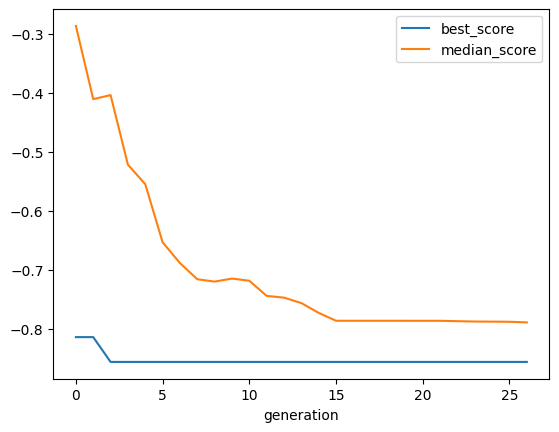

In [25]:
synth.plot_history()

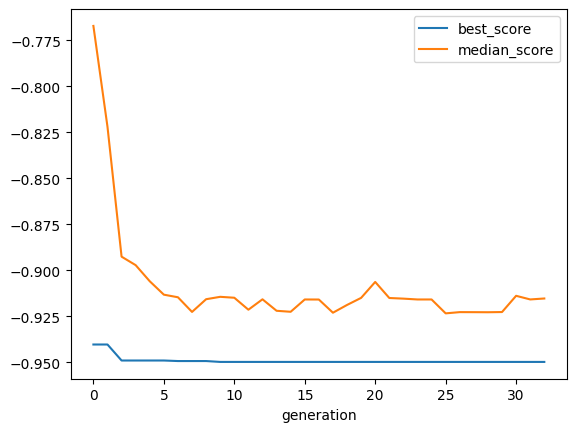

In [26]:
selector.plot_history()

In [ ]:
z